#### BATSMAN MODEL TRAINING

In [1]:
import pandas as pd
import numpy as np
import joblib
import shap
import matplotlib.pyplot as plt

from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score

from sklearn.ensemble import RandomForestRegressor
from xgboost import XGBRegressor
from lightgbm import LGBMRegressor


e:\INFOSYS-INTERNSHIP\cric-player\venv\Lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
df_batter = pd.read_csv("../data/cleaned/batter_dataset.csv")


In [3]:
X = df_batter[['rolling_avg_5', 'venue_avg', 'pvt_avg', 'pvp_avg', 'career_avg','rolling_strike_rate_10']]
y = df_batter['next_match_runs']

df_batter = df_batter.sort_values('date').reset_index(drop=True)


In [4]:
split = int(len(df_batter) * 0.8)

X_train, X_test = X[:split], X[split:]
y_train, y_test = y[:split], y[split:]


#### Baseline Model

In [5]:
baseline_pred = X_test['rolling_avg_5']

baseline_rmse = np.sqrt(mean_squared_error(y_test, baseline_pred))
baseline_mae = mean_absolute_error(y_test, baseline_pred)
baseline_r2 = r2_score(y_test, baseline_pred)

print("Baseline RMSE:", baseline_rmse)
print("Baseline MAE:", baseline_mae)
print("Baseline R2:", baseline_r2)


Baseline RMSE: 6.785247259185891
Baseline MAE: 5.12119850187266
Baseline R2: -0.12268576185127467


#### RANDOM FOREST MODEL

In [6]:
rf = RandomForestRegressor(
    n_estimators=200,
    max_depth=8,
    random_state=42
)

rf.fit(X_train, y_train)

rf_pred = rf.predict(X_test)


#### XGBOOST MODEL 

In [7]:
xgb = XGBRegressor(
    n_estimators=300,
    learning_rate=0.05,
    max_depth=5,
    subsample=0.8,
    colsample_bytree=0.8,
    random_state=42
)

xgb.fit(X_train, y_train)
xgb_pred = xgb.predict(X_test)


#### LIGHTGBM MODEL

In [8]:
lgb = LGBMRegressor(
    n_estimators=300,
    learning_rate=0.05,
    max_depth=5
)

lgb.fit(X_train, y_train)
lgb_pred = lgb.predict(X_test)


[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000870 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 1449
[LightGBM] [Info] Number of data points in the train set: 42717, number of used features: 6
[LightGBM] [Info] Start training from score 6.044736
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, 

#### EVALUATION FUNCTION (COMMON FOR ALL MODELS)

In [9]:
def evaluate(y_true, y_pred, model_name):
    print(f"\n{model_name}")
    print("RMSE:", np.sqrt(mean_squared_error(y_true, y_pred)))
    print("MAE:", mean_absolute_error(y_true, y_pred))
    print("R2:", r2_score(y_true, y_pred))

evaluate(y_test, rf_pred, "Random Forest")
evaluate(y_test, xgb_pred, "XGBoost")
evaluate(y_test, lgb_pred, "LightGBM")



Random Forest
RMSE: 6.063822945956643
MAE: 4.606756146647694
R2: 0.10335633901047259

XGBoost
RMSE: 6.076385400180058
MAE: 4.605029911416747
R2: 0.0996373277737399

LightGBM
RMSE: 6.075592806538546
MAE: 4.605263834968216
R2: 0.09987219608450337


#### HYPERPARAMETER TUNING

In [10]:
from sklearn.model_selection import GridSearchCV, TimeSeriesSplit
from sklearn.metrics import r2_score, mean_squared_error, mean_absolute_error
import numpy as np

# ------------------------------
# Time Series Split
# ------------------------------
tscv = TimeSeriesSplit(n_splits=3)   # reduced from 5 → faster

# ------------------------------
# Smaller but Effective Grid
# ------------------------------
param_grid = {
    'max_depth': [3, 5, 7],
    'learning_rate': [0.05, 0.1],
    'n_estimators': [200, 300]
}

grid = GridSearchCV(
    estimator=XGBRegressor(random_state=42),
    param_grid=param_grid,
    cv=tscv,
    scoring='neg_root_mean_squared_error',
    n_jobs=-1,
    verbose=1
)

# ------------------------------
# Fit GridSearch
# ------------------------------
grid.fit(X_train, y_train)

print("\nBest Parameters:", grid.best_params_)
print("Best CV RMSE:", -grid.best_score_)

# ------------------------------
# Evaluate on Test Set
# ------------------------------
best_xgb = grid.best_estimator_

y_pred_tuned = best_xgb.predict(X_test)

rmse_tuned = np.sqrt(mean_squared_error(y_test, y_pred_tuned))
mae_tuned = mean_absolute_error(y_test, y_pred_tuned)
r2_tuned = r2_score(y_test, y_pred_tuned)

print("\nTuned XGBoost Test Performance")
print("RMSE:", rmse_tuned)
print("MAE:", mae_tuned)
print("R2:", r2_tuned)

# ------------------------------
# Save Model
# ------------------------------
joblib.dump(best_xgb, "../models/batsman_model.joblib")


Fitting 3 folds for each of 12 candidates, totalling 36 fits

Best Parameters: {'learning_rate': 0.05, 'max_depth': 3, 'n_estimators': 200}
Best CV RMSE: 5.670545085872464

Tuned XGBoost Test Performance
RMSE: 6.057546927627505
MAE: 4.6025358617640615
R2: 0.10521141953124113


['../models/batsman_model.joblib']

In [11]:
joblib.dump(grid.best_estimator_, "../models/batsman_model.joblib")


['../models/batsman_model.joblib']

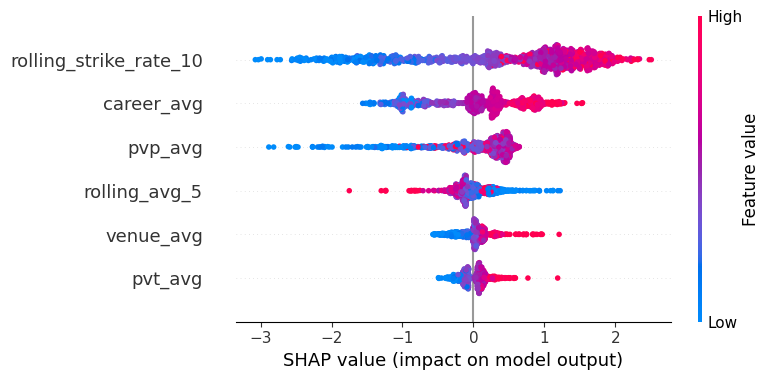

SHAP analysis completed for tuned XGBoost model.


In [12]:
best_model = grid.best_estimator_

# Create SHAP explainer
explainer = shap.TreeExplainer(best_model)

joblib.dump(explainer, "../models/shap_explainer.pkl")
# Use smaller sample if dataset is large

X_sample = X_test.sample(min(1000, len(X_test)), random_state=42)

# Calculate SHAP values
shap_values = explainer.shap_values(X_sample)

# Show summary plot
shap.summary_plot(shap_values, X_sample)

# Save SHAP plot
plt.figure()
shap.summary_plot(shap_values, X_sample, show=False)
plt.savefig("../models/batsman_shap_summary.png", bbox_inches='tight')
plt.close()

print("SHAP analysis completed for tuned XGBoost model.")

#### BOWLER MODEL TRAINING


In [14]:
df_bowler = pd.read_csv("../data/cleaned/bowler_dataset.csv")

# ---------------------------------
# Feature Selection (MATCHING YOUR NOTEBOOK)
# ---------------------------------
X = df_bowler[
    [
        'rolling_avg_wickets',
        'overs_bowled_last5',
        'venue_wicket_rate',
        'bowler_career_avg'
    ]
]

y = df_bowler['next_match_wicket']   # IMPORTANT: singular

# ---------------------------------
# Sort by Date (Time-Aware Split)
# ---------------------------------
df_bowler = df_bowler.sort_values('date').reset_index(drop=True)

In [15]:
split = int(len(df_bowler) * 0.8)

X_train, X_test = X[:split], X[split:]
y_train, y_test = y[:split], y[split:]


In [16]:
# ---------------------------------
# Baseline (rolling_avg_wickets)
# ---------------------------------
baseline_pred = X_test['rolling_avg_wickets']

print("Baseline RMSE:", np.sqrt(mean_squared_error(y_test, baseline_pred)))
print("Baseline MAE:", mean_absolute_error(y_test, baseline_pred))
print("Baseline R2:", r2_score(y_test, baseline_pred))

Baseline RMSE: 1.1760454917482197
Baseline MAE: 0.9171352074966532
Baseline R2: -0.15760466462448286


In [17]:
# ---------------------------------
# Train Basic Models
# ---------------------------------
rf = RandomForestRegressor(
    n_estimators=200,
    max_depth=8,
    random_state=42
)

rf.fit(X_train, y_train)
rf_pred = rf.predict(X_test)

In [18]:
xgb = XGBRegressor(
    n_estimators=300,
    learning_rate=0.05,
    max_depth=5,
    subsample=0.8,
    colsample_bytree=0.8,
    random_state=42
)

xgb.fit(X_train, y_train)
xgb_pred = xgb.predict(X_test)

In [19]:
lgb = LGBMRegressor(
    n_estimators=300,
    learning_rate=0.05,
    max_depth=5
)

lgb.fit(X_train, y_train)
lgb_pred = lgb.predict(X_test)

[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000528 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 666
[LightGBM] [Info] Number of data points in the train set: 9958, number of used features: 4
[LightGBM] [Info] Start training from score 0.992770
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, be

In [20]:
# ---------------------------------
# Evaluation Function
# ---------------------------------
def evaluate(y_true, y_pred, model_name):
    print(f"\n{model_name}")
    print("RMSE:", np.sqrt(mean_squared_error(y_true, y_pred)))
    print("MAE:", mean_absolute_error(y_true, y_pred))
    print("R2:", r2_score(y_true, y_pred))

evaluate(y_test, rf_pred, "Random Forest")
evaluate(y_test, xgb_pred, "XGBoost")
evaluate(y_test, lgb_pred, "LightGBM")




Random Forest
RMSE: 1.0834109349988548
MAE: 0.8415121787198919
R2: 0.017577151138484792

XGBoost
RMSE: 1.0911837256669585
MAE: 0.8522519546759176
R2: 0.0034300546903882623

LightGBM
RMSE: 1.0897555407646173
MAE: 0.8492652093869741
R2: 0.0060370487091634395


In [21]:
# ---------------------------------
# Hyperparameter Tuning (Fast Grid)
# ---------------------------------
tscv = TimeSeriesSplit(n_splits=3)

param_grid = {
    'max_depth': [3, 5, 7],
    'learning_rate': [0.05, 0.1],
    'n_estimators': [200, 300]
}

grid = GridSearchCV(
    estimator=XGBRegressor(random_state=42),
    param_grid=param_grid,
    cv=tscv,
    scoring='neg_root_mean_squared_error',
    n_jobs=-1,
    verbose=1
)

grid.fit(X_train, y_train)

print("\nBest Parameters:", grid.best_params_)
print("Best CV RMSE:", -grid.best_score_)

Fitting 3 folds for each of 12 candidates, totalling 36 fits

Best Parameters: {'learning_rate': 0.05, 'max_depth': 3, 'n_estimators': 200}
Best CV RMSE: 1.0346949349026773


In [22]:
# ---------------------------------
# Evaluate Tuned Model
# ---------------------------------
best_xgb_bowler = grid.best_estimator_

y_pred_tuned = best_xgb_bowler.predict(X_test)

rmse_tuned = np.sqrt(mean_squared_error(y_test, y_pred_tuned))
mae_tuned = mean_absolute_error(y_test, y_pred_tuned)
r2_tuned = r2_score(y_test, y_pred_tuned)

print("\nTuned Bowler XGBoost Test Performance")
print("RMSE:", rmse_tuned)
print("MAE:", mae_tuned)
print("R2:", r2_tuned)

# ---------------------------------
# Save Bowler Model
# ---------------------------------
joblib.dump(best_xgb_bowler, "../models/bowler_model.joblib")


Tuned Bowler XGBoost Test Performance
RMSE: 1.0836216641213055
MAE: 0.8414277522678835
R2: 0.01719494115358744


['../models/bowler_model.joblib']

In [23]:
# ---------------------------------
# SHAP Analysis
# ---------------------------------
explainer = shap.TreeExplainer(best_xgb_bowler)

joblib.dump(explainer, "../models/bowler_shap_explainer.pkl")

X_sample = X_test.sample(min(1000, len(X_test)), random_state=42)

shap_values = explainer.shap_values(X_sample)

plt.figure()
shap.summary_plot(shap_values, X_sample, show=False)
plt.savefig("../models/bowler_shap_summary.png", bbox_inches='tight')
plt.close()

print("SHAP analysis completed for tuned Bowler XGBoost model.")

SHAP analysis completed for tuned Bowler XGBoost model.
